In [60]:
# imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from PIL import Image

In [ ]:
# constants
DATA_DIR = 'Hey-Waldo'  # Path to the Hey-Waldo dataset
FEATURES_DIR = 'waldo-features'  # Path to the features dataset
IMAGE_SIZE = 256  # Choose one size for simplicity (e.g., 256x256)
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.0005
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
# CNN model for individual feature detection
class FeatureCNN(nn.Module):
    def __init__(self, num_classes):
        super(FeatureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [63]:
class WaldoFeatureDataset(Dataset):
    def __init__(self, parent_dir, transform=None):
        self.parent_dir = parent_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through each feature folder (glasses, shirt, hat, face) - also applicable to waldo notwaldo
        for subdir in os.listdir(parent_dir):
            subdir_path = os.path.join(parent_dir, subdir)
            # print(f"Loading {subdir} from {subdir_path}")
            for img in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img)
                
                # print(f"Loading {img} from {img_path}")
                if os.path.isfile(img_path):
                    # Label the image as 1 if it's in the "feature" folder, else 0 if it's in the "notfeature" folder
                    label = 1 if 'not' not in img else 0
                    self.image_paths.append(img_path)
                    self.labels.append(label)

        # Debug print to verify image loading
        # print(f"Loaded {len(self.image_paths)} images from {parent_dir}")
        # print(f"Labels: {self.labels}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label



In [64]:
# Preprocessing and augmentation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [65]:
# Datasets for individual features and general Waldo
feature_datasets = {}
feature_models = {}
print(f"Full path to waldo-features: {os.path.abspath(FEATURES_DIR)}")
print(os.path.join(FEATURES_DIR, 'glasses'))


for feature in ['glasses', 'shirt', 'hat', 'face']:
    label = 0
    dataset = WaldoFeatureDataset(os.path.join(FEATURES_DIR, feature), transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = FeatureCNN(num_classes=2).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training Loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        for inputs, labels in tqdm(dataloader, desc=f"Training {feature} model"):

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(f"Input batch size: {inputs.size(0)}, Labels batch size: {labels.size(0)}")  # Debug print
            # print(f"Output batch size: {outputs.size(0)}, Labels batch size: {labels.size(0)}")  # Debug print

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(dataloader)
        epoch_accuracy = correct_preds / total_preds
        print(f"[{feature}] Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")
    
    feature_models[feature] = model
    
    # increment label so each feature has a unique label
    label += 1

Full path to waldo-features: c:\Users\Caleb\Documents\College\Sophomore Year\Semester 2\Data and Models II\Project\Waldo-Finder\waldo-features
waldo-features\glasses


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


[glasses] Epoch 1/10 - Loss: 0.6949 - Accuracy: 0.5000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


[glasses] Epoch 2/10 - Loss: 0.5247 - Accuracy: 0.7000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


[glasses] Epoch 3/10 - Loss: 1.6521 - Accuracy: 0.5000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


[glasses] Epoch 4/10 - Loss: 0.4637 - Accuracy: 0.9500


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


[glasses] Epoch 5/10 - Loss: 0.5408 - Accuracy: 0.5000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]


[glasses] Epoch 6/10 - Loss: 0.5108 - Accuracy: 0.5500


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


[glasses] Epoch 7/10 - Loss: 0.3893 - Accuracy: 0.9000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


[glasses] Epoch 8/10 - Loss: 0.3076 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


[glasses] Epoch 9/10 - Loss: 0.2294 - Accuracy: 1.0000


Training glasses model: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


[glasses] Epoch 10/10 - Loss: 0.1211 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


[shirt] Epoch 1/10 - Loss: 0.6910 - Accuracy: 0.5000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


[shirt] Epoch 2/10 - Loss: 0.6594 - Accuracy: 0.5000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


[shirt] Epoch 3/10 - Loss: 1.3156 - Accuracy: 0.5000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


[shirt] Epoch 4/10 - Loss: 0.6313 - Accuracy: 0.5000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]


[shirt] Epoch 5/10 - Loss: 0.5861 - Accuracy: 0.6500


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


[shirt] Epoch 6/10 - Loss: 0.6235 - Accuracy: 0.5000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]


[shirt] Epoch 7/10 - Loss: 0.5878 - Accuracy: 0.5500


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]


[shirt] Epoch 8/10 - Loss: 0.5279 - Accuracy: 0.9000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


[shirt] Epoch 9/10 - Loss: 0.4667 - Accuracy: 1.0000


Training shirt model: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


[shirt] Epoch 10/10 - Loss: 0.4061 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


[hat] Epoch 1/10 - Loss: 0.6967 - Accuracy: 0.5000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


[hat] Epoch 2/10 - Loss: 0.6632 - Accuracy: 0.5000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


[hat] Epoch 3/10 - Loss: 0.9113 - Accuracy: 0.5000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


[hat] Epoch 4/10 - Loss: 0.4562 - Accuracy: 0.8500


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


[hat] Epoch 5/10 - Loss: 0.2708 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]


[hat] Epoch 6/10 - Loss: 0.2007 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


[hat] Epoch 7/10 - Loss: 0.0853 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]


[hat] Epoch 8/10 - Loss: 0.0325 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


[hat] Epoch 9/10 - Loss: 0.0243 - Accuracy: 1.0000


Training hat model: 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


[hat] Epoch 10/10 - Loss: 0.0099 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


[face] Epoch 1/10 - Loss: 0.6952 - Accuracy: 0.3500


Training face model: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


[face] Epoch 2/10 - Loss: 0.6043 - Accuracy: 0.5000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]


[face] Epoch 3/10 - Loss: 1.3673 - Accuracy: 0.5000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


[face] Epoch 4/10 - Loss: 0.5556 - Accuracy: 0.5500


Training face model: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]


[face] Epoch 5/10 - Loss: 0.5580 - Accuracy: 0.6500


Training face model: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


[face] Epoch 6/10 - Loss: 0.5565 - Accuracy: 0.6000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


[face] Epoch 7/10 - Loss: 0.4764 - Accuracy: 0.8000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


[face] Epoch 8/10 - Loss: 0.3798 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


[face] Epoch 9/10 - Loss: 0.3025 - Accuracy: 1.0000


Training face model: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

[face] Epoch 10/10 - Loss: 0.1989 - Accuracy: 1.0000


In [66]:
#debugging
from PIL import Image

image_path = "waldo-features/glasses/glasses_0.png"  # Update with an actual image path
try:
    img = Image.open(image_path)
    img.verify()  # Verify that the image is valid
    print(f"Image {image_path} is valid.")
except Exception as e:
    print(f"Error with {image_path}: {e}")

Error with waldo-features/glasses/glasses_0.png: [Errno 2] No such file or directory: 'waldo-features/glasses/glasses_0.png'


In [67]:
import os
from torch.utils.data import Dataset
from PIL import Image

class WaldoNotWaldoDataset(Dataset):
    def __init__(self, image_folder, transform=None, notwaldo_sample_rate=10):
        self.image_folder = image_folder
        self.transform = transform
        self.notwaldo_sample_rate = notwaldo_sample_rate  # Every 10th notwaldo image
        self.image_paths = []
        self.labels = []

        # Iterate through 'waldo' and 'notwaldo' folders
        for label, category in enumerate(['waldo', 'notwaldo']):
            category_path = os.path.join(image_folder, category)
            print(f"Loading {category} images from {category_path}")
            if os.path.isdir(category_path):
                img_names = os.listdir(category_path)
                
                if category == 'waldo':
                    # Add all waldo images
                    for img_name in img_names:
                        img_path = os.path.join(category_path, img_name)
                        if os.path.isfile(img_path):
                            self.image_paths.append(img_path)
                            self.labels.append(label)
                elif category == 'notwaldo':
                    # Add every nth notwaldo image (e.g., every 10th image)
                    for idx, img_name in enumerate(img_names):
                        if idx % self.notwaldo_sample_rate == 0:
                            img_path = os.path.join(category_path, img_name)
                            if os.path.isfile(img_path):
                                self.image_paths.append(img_path)
                                self.labels.append(label)

        # Debug print to verify image loading
        print(f"Loaded {len(self.image_paths)} images from {image_folder}")
        print(f"Labels: {self.labels}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [68]:
# General Waldo vs Not-Waldo CNN
dataset = WaldoNotWaldoDataset(os.path.join(DATA_DIR, '256'), transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

model = FeatureCNN(num_classes=2).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for inputs, labels in tqdm(dataloader, desc="Training Waldo vs Not-Waldo model"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / total_preds
    print(f"[Waldo] Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")


Loading waldo images from Hey-Waldo\256\waldo
Loading notwaldo images from Hey-Waldo\256\notwaldo
Loaded 60 images from Hey-Waldo\256
Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


[Waldo] Epoch 1/10 - Loss: 1.0007 - Accuracy: 0.4833


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


[Waldo] Epoch 2/10 - Loss: 0.7688 - Accuracy: 0.5167


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]


[Waldo] Epoch 3/10 - Loss: 0.6692 - Accuracy: 0.5167


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


[Waldo] Epoch 4/10 - Loss: 0.6539 - Accuracy: 0.7000


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


[Waldo] Epoch 5/10 - Loss: 0.6200 - Accuracy: 0.7500


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


[Waldo] Epoch 6/10 - Loss: 0.5856 - Accuracy: 0.7000


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


[Waldo] Epoch 7/10 - Loss: 0.5326 - Accuracy: 0.7500


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


[Waldo] Epoch 8/10 - Loss: 0.4654 - Accuracy: 0.8667


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


[Waldo] Epoch 9/10 - Loss: 0.4112 - Accuracy: 0.8333


Training Waldo vs Not-Waldo model: 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

[Waldo] Epoch 10/10 - Loss: 0.3319 - Accuracy: 0.8833


In [69]:
# Transformation for consistent preprocessing
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [70]:
def ensemble_predict(models, image_tensor, weights=None, threshold=0.5):
    """
    Get weighted ensemble prediction from multiple models
    
    Args:
        models: List of trained models
        image_tensor: Preprocessed input tensor
        weights: Weight for each model (None for equal weights)
        threshold: Confidence threshold for positive detection
    
    Returns:
        prediction: 1 for Waldo detected, 0 for not detected
        confidence: Confidence score (0-1)
    """
    # Default to equal weights if none provided
    if weights is None:
        weights = [1.0/len(models)] * len(models)
    
    # Ensure weights are normalized
    weights = np.array(weights) / sum(weights)
    
    # Get predictions from each model
    confidences = []
    
    for model in models:
        with torch.no_grad():
            output = model(image_tensor.unsqueeze(0).to(DEVICE))
            probs = F.softmax(output, dim=1)
            # Extract the probability for the "Waldo" class (class 1)
            waldo_prob = probs[0, 1].item()
            confidences.append(waldo_prob)
    
    # Compute weighted average confidence
    weighted_confidence = sum(w * conf for w, conf in zip(weights, confidences))
    
    # Make final prediction based on threshold
    prediction = 1 if weighted_confidence > threshold else 0
    
    return prediction, weighted_confidence, confidences

In [75]:
def sliding_window_detection(models, image, window_size=256, step_size=128, weights=None, threshold=0.5):
    """
    Apply sliding window detection to find Waldo in a larger image
    
    Args:
        models: List of trained models
        image: RGB image as numpy array
        window_size: Size of sliding window
        step_size: Step size for sliding window
        weights: Weight for each model
        threshold: Confidence threshold
    
    Returns:
        bounding_boxes: List of detected regions (x1, y1, x2, y2)
        heatmap: Confidence heatmap
        max_confidence: Maximum confidence detected
    """
    h, w, _ = image.shape
    bounding_boxes = []
    confidences = []
    heatmap = np.zeros((h, w))
    
    for y in range(0, h - window_size + 1, step_size):
        for x in range(0, w - window_size + 1, step_size):
            # Extract window
            window = image[y:y + window_size, x:x + window_size]
            
            # Convert to PIL and preprocess
            window_pil = Image.fromarray(window)
            window_tensor = transform(window_pil)
            
            # Get ensemble prediction
            pred, confidence, _ = ensemble_predict(models, window_tensor, weights, threshold)
            
            if pred == 1:  # Waldo detected
                bounding_boxes.append((x, y, x + window_size, y + window_size))
                confidences.append(confidence)
                
                # Update heatmap - add confidence value
                heatmap[y:y + window_size, x:x + window_size] += confidence
    
    # Normalize heatmap for visualization
    if np.max(heatmap) > 0:
        heatmap = heatmap / np.max(heatmap)
    
    max_confidence = max(confidences) if confidences else 0
    
    return bounding_boxes, heatmap, max_confidence

In [77]:
def visualize_detections(image, bounding_boxes, heatmap, confidences=None, save_path=None):
    """
    Visualize detection results with bounding boxes and heatmap
    """
    plt.figure(figsize=(12, 10))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    image_with_boxes = image.copy()
    
    # Draw bounding boxes
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        conf_text = f"{confidences[i]:.2f}" if confidences else ""
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 0, 0), 3)
        cv2.putText(image_with_boxes, conf_text, (x1, y1-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    
    plt.imshow(image_with_boxes)
    plt.title("Waldo Detections")
    plt.axis('off')
    
    # Plot heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, cmap='hot', alpha=0.5)
    plt.title("Detection Confidence Heatmap")
    plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [72]:

def find_waldo(models, image_path, weights=None, threshold=0.5, visualize=True):
    """
    Main function to find Waldo in an image
    
    Args:
        models: List of trained models
        image_path: Path to image file
        weights: Optional weights for models
        threshold: Confidence threshold
        visualize: Whether to visualize results
    
    Returns:
        found: Boolean indicating whether Waldo was found
        max_confidence: Maximum confidence score
        bounding_boxes: List of detection regions
    """
    # Load and prepare image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # For small images, just use direct prediction
    if max(image.shape[:2]) < 500:
        img_pil = Image.fromarray(image).convert('RGB')
        img_tensor = transform(img_pil)
        pred, confidence, individual_confidences = ensemble_predict(models, img_tensor, weights, threshold)
        
        print(f"Direct prediction: {'Waldo found!' if pred == 1 else 'No Waldo detected.'}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Individual model confidences: {[f'{c:.4f}' for c in individual_confidences]}")
        
        return pred == 1, confidence, []
    
    # For larger images, use sliding window
    bounding_boxes, heatmap, max_confidence = sliding_window_detection(
        models, image, window_size=256, step_size=128, 
        weights=weights, threshold=threshold
    )
    
    # Visualize results if requested
    if visualize and len(bounding_boxes) > 0:
        visualize_detections(image, bounding_boxes, heatmap)
    
    found = len(bounding_boxes) > 0
    print(f"Sliding window detection: {'Waldo found!' if found else 'No Waldo detected.'}")
    print(f"Max confidence: {max_confidence:.4f}")
    print(f"Detections: {len(bounding_boxes)}")
    
    return found, max_confidence, bounding_boxes

In [73]:

class FeatureCNN(torch.nn.Module):
    """
    CNN model definition (copy from the notebook)
    """
    def __init__(self, num_classes):
        super(FeatureCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 256 * IMAGE_SIZE // 8 * IMAGE_SIZE // 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

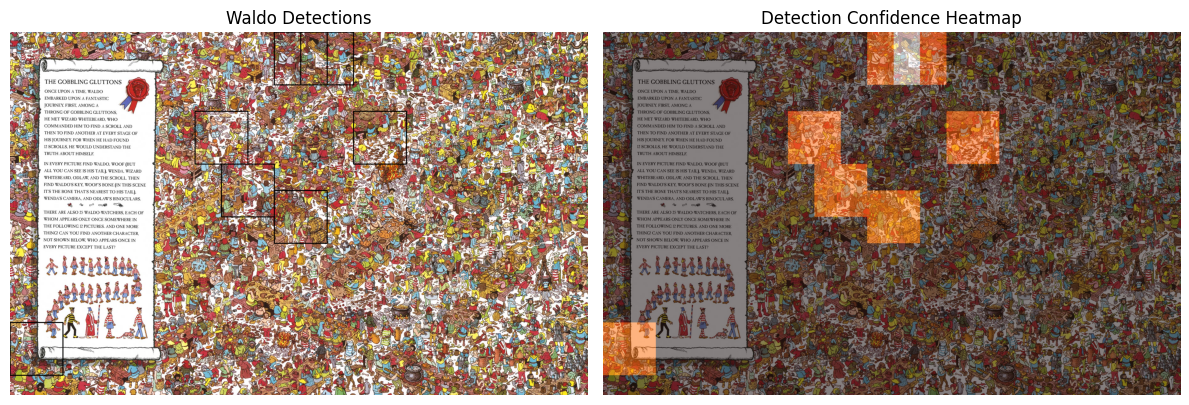

Sliding window detection: Waldo found!
Max confidence: 0.5684
Detections: 7


In [102]:
# Example usage
if __name__ == "__main__":
    # Use the already trained models from the notebook
    # Assuming feature_models is a dictionary with the 4 feature models
    # and 'model' is the general Waldo vs Not-Waldo model
    
    # Collect all models in a list
    models = []
    
    # Add the feature models (glasses, shirt, hat, face)
    # Replace this with your actual variable names if different
    for feature in ['glasses', 'shirt', 'hat', 'face']:
        if feature in feature_models:
            models.append(feature_models[feature])
    
    # Add the general Waldo model (the last model trained in the notebook)
    # Replace 'model' with the actual variable name of your general Waldo model
    models.append(model)  # This should be your general Waldo model
    
    # Make sure all models are in evaluation mode
    for model in models:
        model.eval()
    
    # Optional: Define model weights (higher for better performing models)
    # Default is equal weights if None is passed
    weights = [0.2, 0.05, 0.2, 0.10, 0.45]  # Giving more weight to the general Waldo model
    
    # Test on a single image
    test_image_path = "Hey-Waldo/original-images/5.jpg"
    found, confidence, boxes = find_waldo(
        models, 
        test_image_path,
        weights=weights,
        threshold=0.5,  # Adjust threshold as needed
        visualize=True
    )
    
    # Process a directory of images
    def process_directory(dir_path, output_dir=None):
        """Process all images in a directory"""
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        results = []
        
        for img_file in os.listdir(dir_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(dir_path, img_file)
                print(f"\nProcessing {img_file}...")
                
                found, confidence, boxes = find_waldo(
                    models, img_path, weights=weights, 
                    threshold=0.5, visualize=False
                )
                
                results.append({
                    'image': img_file,
                    'waldo_found': found,
                    'confidence': confidence,
                    'num_detections': len(boxes)
                })
                
                # Save visualization to output directory if provided
                if output_dir and found:
                    output_path = os.path.join(output_dir, f"detected_{img_file}")
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    bounding_boxes, heatmap, _ = sliding_window_detection(
                        models, image, weights=weights, threshold=0.5
                    )
                    confidences = [0.0] * len(bounding_boxes)  # Placeholder if not available
                    visualize_detections(image, bounding_boxes, heatmap, 
                                         confidences, save_path=output_path)
        
        return results
    
    # Example directory processing
    # results = process_directory("test_images", "output_images")
    # for result in results:
    #     print(result)

In [ ]:

def evaluate_model_combinations():
    """
    Evaluate different combinations of models and weights
    to find the optimal configuration
    """
    # Define test cases
    test_images = [
        {"path": "Hey-Waldo/original-images/5.jpg", "has_waldo": True},
        {"path": "Hey-Waldo/original-images/7.jpg", "has_waldo": True},
        {"path": "Hey-Waldo/256/notwaldo/4_2_0.jpg", "has_waldo": False},
        {"path": "Hey-Waldo/256/notwaldo/1_0_0.jpg", "has_waldo": False},
    ]
    
    # Define weight combinations to test
    weight_combinations = [
        # Equal weights
        [0.2, 0.2, 0.2, 0.2, 0.2],
        # Emphasize general Waldo model
        [0.1, 0.1, 0.1, 0.1, 0.6],
        # Emphasize feature models
        [0.25, 0.25, 0.25, 0.25, 0],
        # Custom weights based on individual model performance
        [0.15, 0.2, 0.15, 0.2, 0.3],
    ]
    
    # Test thresholds
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    
    results = []
    
    for weights in weight_combinations:
        for threshold in thresholds:
            correct = 0
            false_positives = 0
            false_negatives = 0
            
            for test in test_images:
                found, _, _ = find_waldo(
                    models, 
                    test["path"],
                    weights=weights,
                    threshold=threshold,
                    visualize=False
                )
                
                if found == test["has_waldo"]:
                    correct += 1
                elif found and not test["has_waldo"]:
                    false_positives += 1
                elif not found and test["has_waldo"]:
                    false_negatives += 1
            
            accuracy = correct / len(test_images)
            results.append({
                "weights": weights,
                "threshold": threshold,
                "accuracy": accuracy,
                "false_positives": false_positives,
                "false_negatives": false_negatives
            })
    
    # Find best configuration
    best_result = max(results, key=lambda x: x["accuracy"])
    print("Best configuration:")
    print(f"Weights: {best_result['weights']}")
    print(f"Threshold: {best_result['threshold']}")
    print(f"Accuracy: {best_result['accuracy']:.4f}")
    print(f"False positives: {best_result['false_positives']}")
    print(f"False negatives: {best_result['false_negatives']}")
    
    return best_result




Evaluating 5 models
Sliding window detection: Waldo found!
Max confidence: 0.4526
Detections: 66
Sliding window detection: Waldo found!
Max confidence: 0.4136
Detections: 35
Direct prediction: No Waldo detected.
Confidence: 0.1851
Individual model confidences: ['0.2958', '0.3123', '0.0000', '0.0536', '0.2637']
Direct prediction: Waldo found!
Confidence: 0.3245
Individual model confidences: ['0.0366', '0.4737', '0.1697', '0.0954', '0.8470']
Sliding window detection: Waldo found!
Max confidence: 0.4526
Detections: 5
Sliding window detection: Waldo found!
Max confidence: 0.4136
Detections: 1
Direct prediction: No Waldo detected.
Confidence: 0.1851
Individual model confidences: ['0.2958', '0.3123', '0.0000', '0.0536', '0.2637']
Direct prediction: No Waldo detected.
Confidence: 0.3245
Individual model confidences: ['0.0366', '0.4737', '0.1697', '0.0954', '0.8470']
Sliding window detection: No Waldo detected.
Max confidence: 0.0000
Detections: 0
Sliding window detection: No Waldo detected.
M

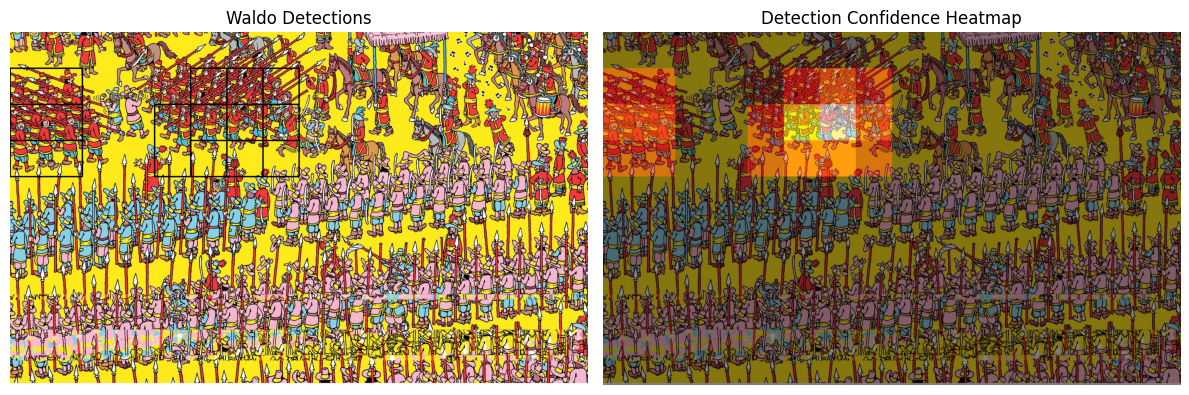

Sliding window detection: Waldo found!
Max confidence: 0.4280
Detections: 7
Found Waldo: True
Confidence: 0.4280
Saved best configuration to best_waldo_config.json


In [101]:
# Example usage with your trained models
if __name__ == "__main__":
    # First make sure your models are defined and loaded
    # Either through the fix from earlier or your own implementation
    
    # Create a list of the models to evaluate
    models_to_evaluate = []
    
    # Add feature models
    for feature in feature_models:
        models_to_evaluate.append(feature_models[feature])
        
    # Add general model
    models_to_evaluate.append(model)
    
    # Make sure all models are in evaluation mode
    for model_instance in models_to_evaluate:
        model_instance.eval()
        
    print(f"Evaluating {len(models_to_evaluate)} models")
    
    # Path to your test dataset
    # This should ideally have a "waldo" and "no_waldo" subfolder
    # Or just a collection of test images
    dataset_path = "Hey-Waldo/test-images"
    
    # Run the evaluation
    best_config = evaluate_model_combinations()
    
    if best_config:
        print("\nApplying best configuration to an example image...")
        
        # Test the best configuration on a single image
        test_image_path = "Hey-Waldo/original-images/1.jpg"
        found, confidence, boxes = find_waldo(
            models_to_evaluate, 
            test_image_path,
            weights=best_config["weights"],
            threshold=best_config["threshold"],
            visualize=True  # Show visualization
        )
        
        print(f"Found Waldo: {found}")
        print(f"Confidence: {confidence:.4f}")
        
        # Save the best configuration
        try:
            import json
            config_output = {
                "weights": [float(w) for w in best_config["weights"]],
                "threshold": float(best_config["threshold"]),
                "accuracy": float(best_config["accuracy"]),
                "false_positives": best_config["false_positives"],
                "false_negatives": best_config["false_negatives"]
            }
            
            with open("best_waldo_config.json", "w") as f:
                json.dump(config_output, f, indent=4)
                
            print("Saved best configuration to best_waldo_config.json")
        except Exception as e:
            print(f"Could not save configuration: {e}")

In [ ]:
# Function to perform sliding window over an image
def sliding_window(image, window_size=256, step_size=128):
    h, w, _ = image.shape
    for y in range(0, h - window_size, step_size):
        for x in range(0, w - window_size, step_size):
            yield (x, y, image[y:y + window_size, x:x + window_size])

In [ ]:
# Function to run sliding window and generate bounding boxes
def generate_bounding_boxes(model, image, transform, threshold=0.5, window_size=256, step_size=128):
    model.eval()  # Set the model to evaluation mode
    bounding_boxes = []
    heatmap = np.zeros(image.shape[:2])  # Initialize the heatmap to zeros
    
    for (x, y, window) in sliding_window(image, window_size, step_size):
        window_image = Image.fromarray(window)
        window_tensor = transform(window_image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(window_tensor)  # Get predictions
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for each class
            waldo_prob = probs[0, 1].item()  # Get the probability for the "waldo" class
            
            if waldo_prob > threshold:  # If the probability exceeds the threshold, it's considered a detection
                # Record the bounding box (top-left, bottom-right)
                bounding_boxes.append((x, y, x + window_size, y + window_size))
                heatmap[y:y + window_size, x:x + window_size] += waldo_prob  # Update heatmap

    return bounding_boxes, heatmap

In [ ]:
# Function to visualize the image with bounding boxes
def visualize_bounding_boxes(image, bounding_boxes, heatmap=None):
    # Draw bounding boxes on the image
    image_with_boxes = image.copy()
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 0, 0), 2)  # Green color for boxes
    
    # Optionally, show a heatmap overlaid on the image
    if heatmap is not None:
        plt.imshow(heatmap, cmap='hot', alpha=0.5)  # Overlay heatmap with transparency
        plt.imshow(image_with_boxes)  # Show the image with bounding boxes
    else:
        plt.imshow(image_with_boxes)  # Just show the image with bounding boxes

    plt.axis('off')
    plt.show()

In [ ]:
# Load image for testing
test_image = cv2.imread('Hey-Waldo/original-images/1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
heatmap = np.zeros(test_image.shape[:2])

In [ ]:
import torch.nn.functional as F

def softmax_vote(models, input_tensor):
    """
    Averages softmax outputs across all models and returns the final prediction (0 or 1).
    Returns 1 if average confidence for class 1 is higher, else 0.
    """
    input_tensor = input_tensor.to(DEVICE)
    votes = []

    for model in models:
        model.eval()
        with torch.no_grad():
            output = model(input_tensor.unsqueeze(0))  # Shape: [1, 2]
            softmax_output = F.softmax(output, dim=1)  # Convert to probabilities
            votes.append(softmax_output.squeeze().cpu().numpy())  # Shape: [2]

    # Average across models (shape: [num_models, 2]) → mean probability for each class
    avg_probs = np.mean(votes, axis=0)  # [p(class 0), p(class 1)]
    return 1 if avg_probs[1] > avg_probs[0] else 0




In [ ]:
# Load and transform a test image
test_image_path = "Hey-Waldo/64/waldo/1_4_6.jpg"  # <- update this path
test_image = Image.open(test_image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
input_tensor = transform(test_image)

# Perform majority voting using trained models
prediction = softmax_vote(list(feature_models.values()), input_tensor)
print("Waldo Detected!" if prediction == 1 else "Not Waldo.")



In [ ]:
# Normalize heatmap
heatmap = np.clip(heatmap, 0, 1)

# Display heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the test image (you can change this to your test image path)
test_image = cv2.imread('Hey-Waldo/original-images/1.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Assuming the model is loaded and trained
model = FeatureCNN(num_classes=2).to(DEVICE)  # Example model; make sure to load your trained model

# Run the sliding window and get bounding boxes and heatmap
bounding_boxes, heatmap = generate_bounding_boxes(model, test_image, transform, threshold=0.3, window_size=256, step_size=64)

# Visualize the bounding boxes on the image
visualize_bounding_boxes(test_image, bounding_boxes, heatmap)